In [1]:
#load aiida environment and connect to database
from aiida import load_profile

profile = load_profile()
print('profile name : ',profile.name)
print('profile database host name : ',profile.database_hostname)
print('default user : ',profile.default_user)

profile name :  default
profile database host name :  localhost
default user :  r.mozumder@fz-juelich.de


In [2]:
# load classes and functions
from aiida.orm import CifData, Code, Dict, load_node, StructureData 
from aiida.orm import (Group, load_group, load_node, load_code, groups,
                      WorkChainNode)
from aiida.engine import submit, exceptions
from aiida.common.exceptions import NotExistent
from aiida_kkr.workflows import kkr_imp_sub_wc, kkr_imp_dos, kkr_imp_wc, kkr_startpot_wc
import numpy as np
from aiida_kkr.calculations import KkrimpCalculation, VoronoiCalculation
import matplotlib.pyplot as plt
from aiida_kkr.tools.common_workfunctions import get_username
import matplotlib.gridspec as gridspec
from aiida_kkr.tools import plot_kkr


In [3]:
## This function will help to plot dos_imp
def dos_plot (group_or_wc_list):
    from aiida.orm import load_group, load_node
    if group_or_wc_list == []:
        dos_list= group_or_wc_list
    else:
        try:
            group = load_group(group_or_wc_list)
            dos_list = [i.pk for i in list(group.nodes)[:]]
        except:
            print('{} group is not present is the database.'.format(group_or_wc_list))
   
    for wc in dos_list[:]:
        imp_dos = load_node(wc)
        imp_info = imp_dos.label
        print(imp_info)


        fig2 = plt.figure(figsize=(15.0,4.5))
        spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig2)

        

        # Total contribution from the entire impurity cluster
        f2_ax1 = fig2.add_subplot(spec2[0, 0])
        plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True ,label= 'Impurity_Clu1ter',
                     noshow=True, nofig=True, color='C'+str(0), filled=True, alpha=0.3, yscale=1
                )
        # highlight the contibution of the impurity (iatom=0)
        plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label= imp_dos.label,
                     noshow=True, nofig=True, color='C'+str(0), lw=3, iatom=0, 
                )
        
            

        f2_ax2 = fig2.add_subplot(spec2[0, 1])
        plot_kkr(imp_dos, l_channels=True, strucplot=False, silent=True, label='Impurity_Cluster',
                noshow=True, nofig=True, color='C'+str(0),filled=True, alpha=0.3, yscale=1, sum_spins= True,)
        plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
                noshow=True, nofig=True, color='C'+str(0), lw=3, iatom=0,all_atoms= False, sum_spins= True,)
        print('impurity_dict', imp_dos.inputs.impurity_info.get_dict())
        
        
        
## execution of the function
# dos_plot(94)

In [4]:
# For the given input 'imp_dos node or ID and intended energy points' it will return .
# Total density of states arround the indent eng point, most prominent orbital (s,p,d,...) dos and corresponding
# dos value

def dos_spec(imp_dos_or_pk, atom_index = 0, eng=0, debug=False):
    
    import numpy as np
    from aiida.orm import load_node
    from aiida.common.exceptions import NotExistent 
    from aiida_kkr.calculations import KkrCalculation, VoronoiCalculation
    from aiida_kkr.workflows import kkr_imp_sub_wc, kkr_imp_wc
    
    is_id = None
    node_exist = None
    
    try:
        dos_node = load_node(imp_dos_or_pk)
    except NotExistent as e:
        is_id = False
        node_exist = imp_dos_or_pk.is_stored
        if node_exist:
            dos_node = imp_dos_or_pk


    
    dos_data = dos_node.outputs.dos_data
    dos_data_x = dos_data.get_x()
#     dos_data_x -->> ('E_EF', array([[]]))
    dos_data_y = dos_data.get_y()
    
    if debug:
        print('dos_data_x shape :', np.shape(dos_data_x))
        print('dos_data_y shape :', np.shape(dos_data_y))
    
    # extract the discrete energy list and unit
    discrete_eng, eng_unit = (dos_data_x[1])[0][:], dos_data_x[2]
    if debug:
        print('discrete_eng : ',discrete_eng)
        print('eng_unit : ', eng_unit)
    
    dos_unit = dos_data_y[0][2]
    if debug:
        print('dos_unit : ', dos_unit)
    
    ## In this part only the required dos data will be saved into the dos_data_arr 
    # cut the dos data for total, s, p, ... into that array for tot, s, p, d, more orbital.
   
    # number of dos array e.g., tot, s, p,..orbital
    num = np.shape(dos_data_y)[0]
    if debug:
        print('NUM : ', num)
    
    y_grid = num*2 # to count the spin and down
    x_grid = len(discrete_eng)
    
    if debug:
        print('x_grid, :', x_grid)
        print('y_grid, :', y_grid)

    dos_data_arr = np.zeros((y_grid,x_grid),dtype=float)
    if debug:
        if num == int(y_grid/2):
            print('ok')

    ## The array dos_data_arr consist dos data for the <atom_index> and for all ldos (total, s, p....,ns)
    for i in range(num): 
        l_dos = dos_data_y[i][1]
        dos_data_arr[i*2][:] =  l_dos[atom_index*2][:] # for spin up
        dos_data_arr[i*2+1][:] =  l_dos[atom_index*2 +1][:] # for spin down 
    if debug:    
        print('dos_data_arr shape: ',np.shape(dos_data_arr))
    
    # Find the energy index nearest to eng index
    nearest_eng_point_index = min(range(len(discrete_eng)), key= lambda i : abs(discrete_eng[i] - eng))
    if debug:
        print('min energy : ', nearest_eng_point_index)
    
    ## It returns all the dos along the column at the index <nearest_eng_point_index>
    all_dos = dos_data_arr.T[nearest_eng_point_index][:]
    
    if debug:
        print('shape of the all_dos', np.shape(all_dos))
        print('all_dos data : ',all_dos)
    
    ## total dos_density list at energy point <eng> for an atom <atom index>
    total_dos = [all_dos[0], all_dos[1]]
    ldos_u , ldos_d = [all_dos[2+i] for i in range(len(all_dos[2:])) if i%2==0 ], [all_dos[2+i] for i in range(len(all_dos[2:])) if i%2==1 ]
    # To collecting the lebel from dos_data
    total_dos_label = dos_data_y[0][0]
    #collect the ldos lebel for max_dos spin up and spin down
    ldos_u_label = dos_data_y[np.argmax(ldos_u[:]) + 1][0] 
    ldos_d_label = dos_data_y[np.argmax(ldos_d[:]) + 1][0]
    
    # Collect the max ldos value 
    max_ldos_up_value = np.max(ldos_u)
    max_ldos_down_value = np.max(ldos_d)
    
    # To collec the data for further invetigation e.g. ploting 
    out_dict = {total_dos_label: {total_dos_label+'_spin_up': total_dos[0],
                                      total_dos_label+'_spin_down': total_dos[1]},
                'Most Prominent_ldos': {ldos_u_label + '_spin_up': max_ldos_up_value,
                                      ldos_d_label + '_spin_down': max_ldos_down_value},
                'Units':{'energy_unit': eng_unit,
                         'dos_unit':dos_unit},
                'Other':{'eng':discrete_eng[nearest_eng_point_index],
                         'atom_index':atom_index}
               }
    
    return out_dict
    

In [5]:
## This function will return the desired value from the last calc output_parameters for the given input parameter
## and also some out_parameters from the kkr_imp_scf wc
## DATA has been extructed from dos wc
def conv_dos_data(imp_dos_or_pk, debug= False):
    import numpy as np
    from aiida.orm import load_node
    from aiida_kkr.workflows import kkr_imp_sub_wc
    from aiida.common.exceptions import NotExistent 
    from aiida.common.constants import elements as elmt
    summary_data_dict = { 'rms_conv' : 0,
                          'etot_conv_Ry' : 0,
                          'etot_conv_eV' : 0,
                          'imp_spin_moment_mu_Bhor' : 0,
                          'imp_orbital_moment_mu_Bhor' : 0,
                          'imp_total_charge_electron' : 0,
                          'imp_core_charge_electron' : 0,
                          'charge_doping_electron' : 0, # 
                          'DOS_in_gap' : 0,
                     };
    imp_clst_dict = {'atoms_in_impurity_cluster' : 0,
                     'ilayer' : 0,
                     'Zimp' : 0,
                     'Zhost' : 0
                    }
    
    
    try:
        dos_node = load_node(imp_dos_or_pk)
    except NotExistent as e:
        is_id = False
        node_exist = imp_dos_or_pk.is_stored
        if node_exist:
            dos_node = imp_dos_or_pk
    imp_info = dos_node.inputs.impurity_info.get_dict()
    scf_wc = dos_node.inputs.imp_pot_sfd.get_incoming(node_class = kkr_imp_wc).first().node
    scf_out_param = scf_wc.outputs.last_calc_output_parameters.get_dict()
    
    # To extract the host structure from the using the host_Greenfunction_folder comingout from the kkr_flex_wc
    kkr_sub = dos_node.get_outgoing(node_class=kkr_imp_sub_wc).first().node
    kkrimp_calc = kkr_sub.get_outgoing(node_class= KkrimpCalculation).first().node
    host_greenfuntion_folder = kkrimp_calc.inputs.host_Greenfunction_folder
    host_structure, voro_calc = VoronoiCalculation.find_parent_structure(host_greenfuntion_folder)
    
    
    ## Filling the last calc output data
    imp_atom = 0
    dos_eng = 0
    summary_data_dict['rms_conv'] = scf_out_param['convergence_group']['rms']
    summary_data_dict['etot_conv_Ry'] = scf_out_param['total_energy_Ry']
    summary_data_dict['etot_conv_eV'] = scf_out_param['total_energy_Ry'] * 13.6056980659
    summary_data_dict['imp_spin_moment_mu_Bhor'] = scf_out_param['magnetism_group']['spin_moment_per_atom'][imp_atom][:]
    summary_data_dict['imp_orbital_moment_mu_Bhor'] = scf_out_param['magnetism_group']['orbital_moment_per_atom'][imp_atom][:]
    summary_data_dict['imp_total_charge_electron'] = scf_out_param['total_charge_per_atom'][imp_atom]
    summary_data_dict['imp_core_charge_electron'] = scf_out_param['charge_core_states_per_atom'][imp_atom]
    charge_doping = imp_info['Zimp'] - summary_data_dict['imp_total_charge_electron']
    summary_data_dict['charge_doping_electron'] = charge_doping
    
    spec_dos_data = dos_spec(dos_node, imp_atom, dos_eng,  debug)
    dos_in_gap = spec_dos_data['dos tot']['dos tot_spin_up'] + spec_dos_data['dos tot']['dos tot_spin_down']
    summary_data_dict['DOS_in_gap'] = dos_in_gap

    
    # Filling the imp_cluster data
    cluster_size = len(scf_out_param['total_charge_per_atom'])
    zimp = imp_info['Zimp']
    zhost = 0 # TODO: Have to find it later
    ilayer = imp_info['ilayer_center']
    # To find the Zimp from the host structure
    sym_to_Znum = {val['symbol']:num for num,val in elmt.items() }
    ilayer_host_symbol = host_structure.sites[ilayer].kind_name
    zhost = sym_to_Znum[ilayer_host_symbol]
    
    
    
    
    
    imp_clst_dict['atoms_in_impurity_cluster'] = cluster_size
    imp_clst_dict['ilayer'] = ilayer
    imp_clst_dict['Zimp'] = zimp
    imp_clst_dict['Zhost'] = zhost
    return summary_data_dict, imp_clst_dict

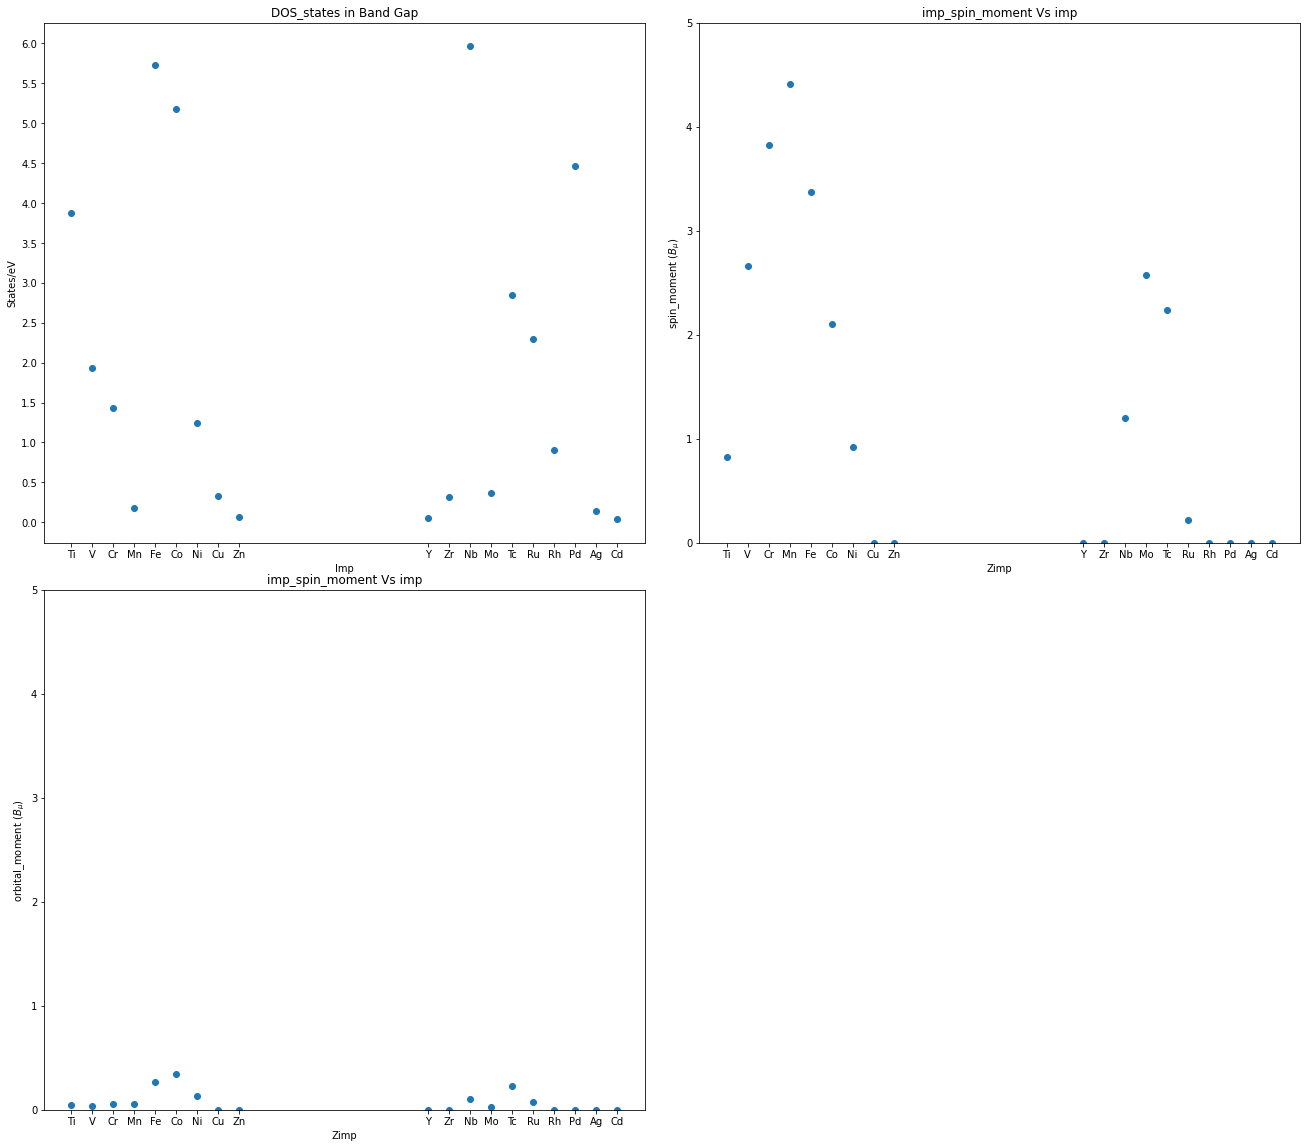

In [244]:
# To plot some data
from aiida.common.constants import elements as elmt

group_ilayer_4 = load_group(107)
node_list = list(group_ilayer_4.nodes)
imp_list = []
gap_dos_list = []
spin_moment_list = []
orbital_moment_list = []

#Hre collect the data for each imp_dos_calc
for i in range(len(node_list)):
    dos_dict, clst_dict = conv_dos_data(node_list[i], debug=False)
    imp_list.append(clst_dict['Zimp'])
    gap_dos_list.append(dos_dict['DOS_in_gap'])

    # Collect the spin moment
    spin_moment = pow(sum([i**2 for i in dos_dict['imp_spin_moment_mu_Bhor']]), 0.5)
    spin_moment_list.append(spin_moment)

    # Collect the orbital moment
    orbital_moment = pow(sum([i**2 for i in dos_dict['imp_orbital_moment_mu_Bhor']]), 0.5)
    orbital_moment_list.append(orbital_moment)


## Plot some out_put_data Vs imp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gdspec
fig = plt.figure(1, figsize=(15*1.5,20))
gdspec.GridSpec(4,4)

# Plot DOS in gap Vs imp
plt.subplot2grid((4,4), (0,0), colspan=2, rowspan=2)
plt.scatter(imp_list, gap_dos_list)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=20)
plt.title('DOS_states in Band Gap')
plt.xlabel('Imp')
plt.ylabel('States/eV')
xlabel = [elmt[i]['symbol'] for i in imp_list[:]]
plt.xticks(imp_list, xlabel)

plt.subplot2grid((4,4), (0,2), colspan=2, rowspan=2)
plt.scatter(imp_list, spin_moment_list)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('imp_spin_moment Vs imp')
plt.xlabel('Zimp')
plt.ylabel('spin_moment ($B_\mu$)')
plt.ylim((0.0,5.0))
xlabel = [elmt[i]['symbol'] for i in imp_list[:]]
plt.xticks(imp_list, xlabel)

plt.subplot2grid((4,4), (2,0), colspan=2, rowspan=2)
plt.scatter(imp_list, orbital_moment_list)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('imp_spin_moment Vs imp')
plt.xlabel('Zimp')
plt.ylabel('orbital_moment ($B_\mu$)')
plt.ylim((0.0,5.0))
xlabel = [elmt[i]['symbol'] for i in imp_list[:]]
plt.xticks(imp_list, xlabel)

plt.show()

In [6]:
### To extract data from the two combine impurities as well as single imp to plot 3D plot:
import numpy as np
from aiida.common.constants import elements as elmt
#def extrac(group)
combine_imps_group = load_group(102)
combine_nodes_list = list(combine_imps_group.nodes)
plot_imp_row_list = []  # This is the list considered as the label for yticks
plot_imp_col_list = ['xx']  # This is the list considered as the label for xticks

for node in combine_nodes_list[:]:
    ## Here to arrange the imps for once, intending for x-axis, 
    ## plot_col_list, and y-axis, plot_row_list 
    imp1, imp2 = node.label.split(':')[0], node.label.split(':')[1]
    ## Here only one imp will be consider for once
    if imp1 not in plot_imp_row_list:
        plot_imp_row_list.append(imp1)
    if imp2 not in plot_imp_col_list:
        plot_imp_col_list.append(imp2)
        
print('len of plot_imp_row_list', len(plot_imp_row_list))
print('len of plot_imp_col_list', len(plot_imp_col_list))


# create meshgrid keepning one extra underneath row and extra left end column
x = np.arange(0, len(plot_imp_col_list), 1)
y = np.arange(0, len(plot_imp_row_list), 1)
xx,yy = np.meshgrid(x,y)


# Extract all the total_pin_momentum from the combine_imps_wc as well as single impurity
def extract_val(group):
    node_list = list(group.nodes)
    extr_comb_dict = {}
    extr_single_dict = {}
    already_search_imp_list= []
    for nod in node_list[:]:
        
        single_imp_wc = nod.inputs.impurity1_output_node.get_incoming(node_class=kkr_imp_wc).first().node
        zimp= single_imp_wc.inputs.impurity_info.get_dict()['Zimp']
        if zimp not in already_search_imp_list:
            already_search_imp_list.append(zimp)
            ## Now collect the spin_data
            try:
                single_imp_val = single_imp_wc.outputs.last_calc_output_parameters.get_dict()['magnetism_group']['total_spin_moment']
            except:
                single_imp_val = 0
            imp1_symbol= elmt[zimp]['symbol']
            extr_single_dict[imp1_symbol]= single_imp_val
        
        key= nod.label.split(':')[0] + nod.label.split(':')[1]
        val= nod.outputs.last_calc_output_parameters.get_dict()['magnetism_group']['total_spin_moment']
        extr_comb_dict[key]= val
        
        
    return extr_comb_dict, extr_single_dict

# To fill the 2d plot data here
spin_data_array = np.zeros(shape= (len(plot_imp_row_list), len(plot_imp_col_list)), dtype= float)
extr_comb_dict, extr_single_dict = extract_val(combine_imps_group)
row_index= 0
col_index= 1 # Here the zero index is skiped as it is fillled with empty string 'xx'
             # and the coresponding column will be filles with the data extracted
             # from the singel imp data

for imp1 in plot_imp_row_list[:]:
    col_index = 1
    for imp2 in plot_imp_col_list[1:]:
        
        if col_index==1:
            ## Here the first column will be fullfiled with the single im_data
            spin_data_array[row_index, col_index-1] = extr_single_dict[imp1]
        search_key = plot_imp_row_list[row_index]  + plot_imp_col_list[col_index]
        if search_key in  extr_comb_dict.keys():
            spin_data_array[row_index, col_index] =  extr_comb_dict[search_key]
            
        col_index += 1
    row_index += 1
    
plot_data_shape = np.shape(spin_data_array)

len of plot_imp_row_list 20
len of plot_imp_col_list 21


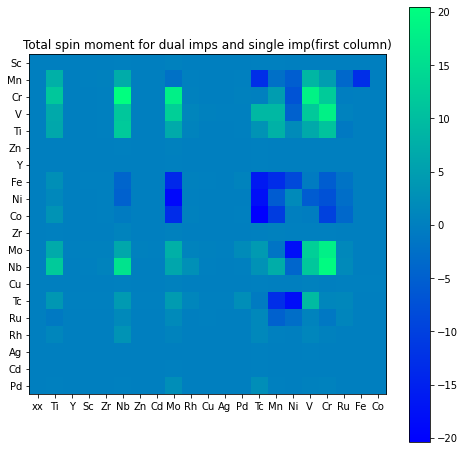

<Figure size 432x288 with 0 Axes>

In [53]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gdspec
fig = plt.figure(1, figsize=(8,8))
# gdspec.GridSpec(4,4)
# To set the xtick points, and xlabels
xtick_points = [xx[0,:]]
xtick_labels = [plot_imp_col_list]
ytick_points = [yy[:,0]]
ytick_labels = [plot_imp_row_list]
cmap = [plt.cm.get_cmap('winter')]
title =['Total spin moment for dual imps and single imp(first column)']

imp1 = plt.imshow(spin_data_array, cmap=cmap[0])
cbar = plt.colorbar(imp1)
plt.locator_params(axis='x', nbins=21)
plt.locator_params(axis='y', nbins=20)
plt.xticks(xtick_points[0], xtick_labels[0])
plt.yticks(ytick_points[0], ytick_labels[0])
plt.title(title[0])

plt.show()
plt.savefig('spin_moment.png')

In [38]:
## Plot 2D data from combine impurity
group_102 = load_group(102)
def TwoDData_extract(group):
    combine_imps_group = load_group(102)
    combine_nodes_list = list(combine_imps_group.nodes)
    time_per_iter = list()
    for node in combine_nodes_list[:]:
        
        last_calc_param = node.outputs.last_calc_output_parameters.get_dict()
        ## To extract the iteration time per iter
        total_running_time = last_calc_param['timings_group']['Total running time']
        total_iter = last_calc_param['convergence_group']['number_of_iterations']
        per_iter = total_running_time/total_iter
        
        time_per_iter.append(per_iter)
    
    return time_per_iter
        
        ##
time_per_iter = TwoDData_extract(group_102)



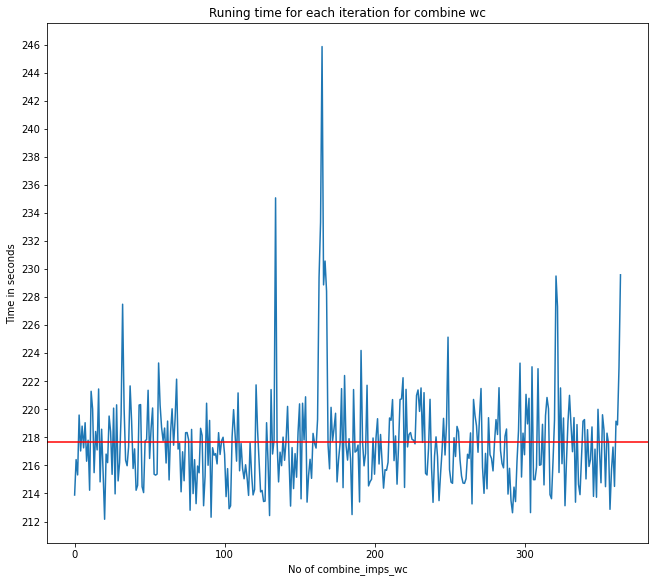

<Figure size 432x288 with 0 Axes>

In [54]:
## Plot some out_put_data Vs imp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gdspec
fig = plt.figure(1, figsize=(15*1.5,20))
gdspec.GridSpec(4,4)

# Plot DOS in gap Vs imp

plt.subplot2grid((4,4), (0,0), colspan=2, rowspan=2)
plt.plot(time_per_iter)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=20)
plt.title('Runing time for each iteration for combine wc')
plt.xlabel('No of combine_imps_wc')
plt.ylabel('Time in seconds')
plt.axhline(np.average(time_per_iter), c='RED')
# xlabel = [elmt[i]['symbol'] for i in imp_list[:]]
# plt.xticks(imp_list, xlabel)


plt.show()
plt.savefig('runtime for iteration.png')

In [48]:
## To plot JijData
combine_imps_group = load_group(102)
combine_nodes_list = list(combine_imps_group.nodes)
plot_imp_row_list = []  # This is the list considered as the label for yticks
plot_imp_col_list = ['xx']  # This is the list considered as the label for xticks

for node in combine_nodes_list[:]:
    ## Here to arrange the imps for once, intending for x-axis, 
    ## plot_col_list, and y-axis, plot_row_list 
    imp1, imp2 = node.label.split(':')[0], node.label.split(':')[1]
    ## Here only one imp will be consider for once
    if imp1 not in plot_imp_row_list:
        plot_imp_row_list.append(imp1)
    if imp2 not in plot_imp_col_list:
        plot_imp_col_list.append(imp2)
        
print('len of plot_imp_row_list', len(plot_imp_row_list))
print('len of plot_imp_col_list', len(plot_imp_col_list))


# create meshgrid keepning one extra underneath row and extra left end column
x = np.arange(0, len(plot_imp_col_list), 1)
y = np.arange(0, len(plot_imp_row_list), 1)
xx,yy = np.meshgrid(x,y)


# Extract all the total_pin_momentum from the combine_imps_wc as well as single impurity
def extract_val(group):
    node_list = list(group.nodes)
    extr_comb_dict = {}
    extr_single_dict = {}
    already_search_imp_list= []
    for nod in node_list[:]:
        
        single_imp_wc = nod.inputs.impurity1_output_node.get_incoming(node_class=kkr_imp_wc).first().node
        zimp= single_imp_wc.inputs.impurity_info.get_dict()['Zimp']
        if zimp not in already_search_imp_list:
            already_search_imp_list.append(zimp)
            ## Now collect the spin_data
            try:
                Jij = single_imp_wc.outputs.JijData.get_array('JijData')[0,3]
            except:
                Jij = 0
            imp1_symbol= elmt[zimp]['symbol']
            extr_single_dict[imp1_symbol]= Jij
        
        key= nod.label.split(':')[0] + nod.label.split(':')[1]
        val= nod.outputs.JijData.get_array('JijData')[0,3]
        extr_comb_dict[key]= val
        
        
    return extr_comb_dict, extr_single_dict

# To fill the 2d plot data here
Jij_data_array = np.zeros(shape= (len(plot_imp_row_list), len(plot_imp_col_list)), dtype= float)
extr_comb_dict, extr_single_dict = extract_val(combine_imps_group)
row_index= 0
col_index= 1 # Here the zero index is skiped as it is fillled with empty string 'xx'
             # and the coresponding column will be filles with the data extracted
             # from the singel imp data

for imp1 in plot_imp_row_list[:]:
    col_index = 1
    for imp2 in plot_imp_col_list[1:]:
        
        if col_index==1:
            ## Here the first column will be fullfiled with the single im_data
            Jij_data_array[row_index, col_index-1] = extr_single_dict[imp1]
        search_key = plot_imp_row_list[row_index]  + plot_imp_col_list[col_index]
        if search_key in  extr_comb_dict.keys():
            Jij_data_array[row_index, col_index] =  extr_comb_dict[search_key]
            
        col_index += 1
    row_index += 1
    
plot_data_shape = np.shape(Jij_data_array)

len of plot_imp_row_list 20
len of plot_imp_col_list 21


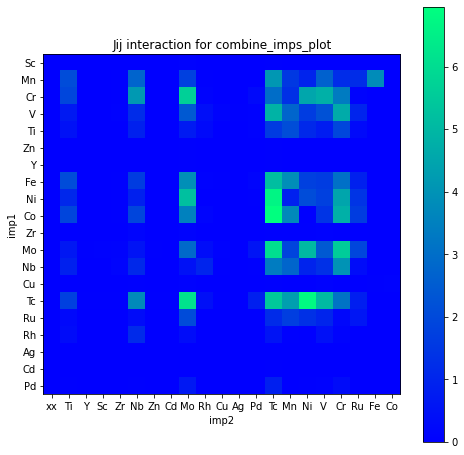

<Figure size 432x288 with 0 Axes>

In [55]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gdspec
fig = plt.figure(1, figsize=(8,8))
# gdspec.GridSpec(4,4)
# To set the xtick points, and xlabels
xtick_points = [xx[0,:]]
xtick_labels = [plot_imp_col_list]
ytick_points = [yy[:,0]]
ytick_labels = [plot_imp_row_list]
cmap = [plt.cm.get_cmap('winter')]
title =['Total spin moment for dual imps and single imp(first column)', 'Jij interaction for combine_imps_plot']

imp1 = plt.imshow(Jij_data_array, cmap=cmap[0])
cbar = plt.colorbar(imp1)
plt.locator_params(axis='x', nbins=21)
plt.locator_params(axis='y', nbins=20)
plt.xticks(xtick_points[0], xtick_labels[0])
plt.yticks(ytick_points[0], ytick_labels[0])
plt.xlabel('imp2')
plt.ylabel('imp1')

plt.title(title[1])

plt.show()
plt.savefig('JijData.png')

In [68]:
## To plot Dyaloshinky data
combine_imps_group = load_group(102)
combine_nodes_list = list(combine_imps_group.nodes)
plot_imp_row_list = []  # This is the list considered as the label for yticks
plot_imp_col_list = ['xx']  # This is the list considered as the label for xticks

for node in combine_nodes_list[:]:
    ## Here to arrange the imps for once, intending for x-axis, 
    ## plot_col_list, and y-axis, plot_row_list 
    imp1, imp2 = node.label.split(':')[0], node.label.split(':')[1]
    ## Here only one imp will be consider for once
    if imp1 not in plot_imp_row_list:
        plot_imp_row_list.append(imp1)
    if imp2 not in plot_imp_col_list:
        plot_imp_col_list.append(imp2)
        
print('len of plot_imp_row_list', len(plot_imp_row_list))
print('len of plot_imp_col_list', len(plot_imp_col_list))


# create meshgrid keepning one extra underneath row and extra left end column
x = np.arange(0, len(plot_imp_col_list), 1)
y = np.arange(0, len(plot_imp_row_list), 1)
xx,yy = np.meshgrid(x,y)


# Extract all the total_pin_momentum from the combine_imps_wc as well as single impurity
def extract_val(group):
    node_list = list(group.nodes)
    extr_comb_dict = {}
    extr_single_dict = {}
    already_search_imp_list= []
    for nod in node_list[:]:
        
        single_imp_wc = nod.inputs.impurity1_output_node.get_incoming(node_class=kkr_imp_wc).first().node
        zimp= single_imp_wc.inputs.impurity_info.get_dict()['Zimp']
        if zimp not in already_search_imp_list:
            already_search_imp_list.append(zimp)
            ## Now collect the spin_data
            try:
                Jij = single_imp_wc.outputs.JijData.get_array('JijData')[0,4]
            except:
                Jij = 0
            imp1_symbol= elmt[zimp]['symbol']
            extr_single_dict[imp1_symbol]= Jij
        
        key= nod.label.split(':')[0] + nod.label.split(':')[1]
        val= nod.outputs.JijData.get_array('JijData')[0,4]
        extr_comb_dict[key]= val
        
        
    return extr_comb_dict, extr_single_dict

# To fill the 2d plot data here
Jij_data_array = np.zeros(shape= (len(plot_imp_row_list), len(plot_imp_col_list)), dtype= float)
extr_comb_dict, extr_single_dict = extract_val(combine_imps_group)
row_index= 0
col_index= 1 # Here the zero index is skiped as it is fillled with empty string 'xx'
             # and the coresponding column will be filles with the data extracted
             # from the singel imp data

for imp1 in plot_imp_row_list[:]:
    col_index = 1
    for imp2 in plot_imp_col_list[1:]:
        
        if col_index==1:
            ## Here the first column will be fullfiled with the single im_data
            Jij_data_array[row_index, col_index-1] = extr_single_dict[imp1]
        search_key = plot_imp_row_list[row_index]  + plot_imp_col_list[col_index]
        if search_key in  extr_comb_dict.keys():
            Jij_data_array[row_index, col_index] =  extr_comb_dict[search_key]
            
        col_index += 1
    row_index += 1
    
plot_data_shape = np.shape(Jij_data_array)

len of plot_imp_row_list 20
len of plot_imp_col_list 21


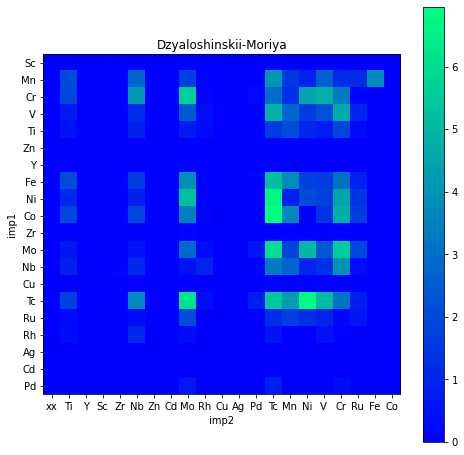

In [72]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gdspec
%matplotlib inline
fig = plt.figure(1, figsize=(8,8))
# gdspec.GridSpec(4,4)
# To set the xtick points, and xlabels
xtick_points = [xx[0,:]]
xtick_labels = [plot_imp_col_list]
ytick_points = [yy[:,0]]
ytick_labels = [plot_imp_row_list]
cmap = [plt.cm.get_cmap('winter')]
title =['Total spin moment for dual imps and single imp(first column)', 'Jij interaction for combine_imps_plot'
        , 'Dzyaloshinskii-Moriya']

imp1 = plt.imshow(Jij_data_array, cmap=cmap[0])
cbar = plt.colorbar(imp1)
plt.locator_params(axis='x', nbins=21)
plt.locator_params(axis='y', nbins=20)
plt.xticks(xtick_points[0], xtick_labels[0])
plt.yticks(ytick_points[0], ytick_labels[0])
plt.xlabel('imp2')
plt.ylabel('imp1')

plt.title(title[2])
plt.savefig('Dzyaloshinskii-Moriya.png', dpi=100.0, pad_inches=.05)
plt.show()


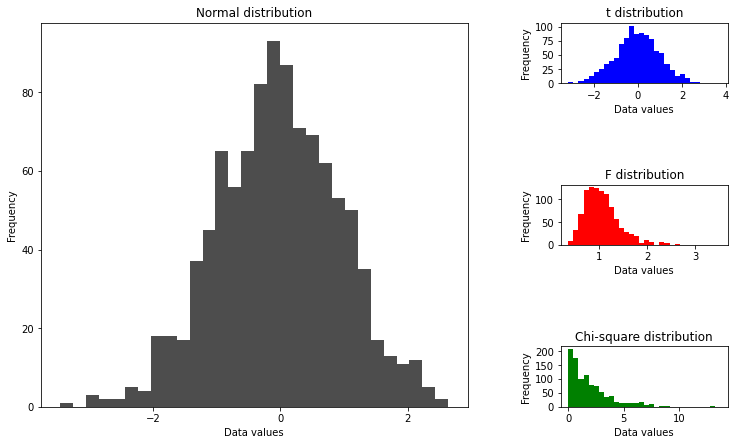

In [23]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Generate data
dist_norm = np.random.normal(loc=0, scale=1, size=1000)
dist_tdis = np.random.standard_t(df=29, size=1000)
dist_fdis = np.random.f(dfnum=59, dfden=28, size=1000)
dist_chsq = np.random.chisquare(df=2, size=1000)

# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(3,3)

# large subplot
plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Normal distribution')
plt.xlabel('Data values')
plt.ylabel('Frequency')
plt.hist(dist_norm, bins=30, color='0.30')

# small subplot 1
plt.subplot2grid((3,3), (0,2))
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('t distribution')
plt.xlabel('Data values')
plt.ylabel('Frequency')
plt.hist(dist_tdis, bins=30, color='b')

# small subplot 2
plt.subplot2grid((3,3), (1,2))
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('F distribution')
plt.xlabel('Data values')
plt.ylabel('Frequency')
plt.hist(dist_fdis, bins=30, color='r')

# small subplot 3
plt.subplot2grid((3,3), (2,2))
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Chi-square distribution')
plt.xlabel('Data values')
plt.ylabel('Frequency')
plt.hist(dist_chsq, bins=30, color='g')

# fit subplots and save fig
fig.tight_layout()
fig.set_size_inches(w=11,h=7)
fig_name = 'plot.png'
fig.savefig(fig_name)